# Cosmology MCMC notebook!

# Preliminaries

In [1]:
# Install required packages (if not available on server)
!pip install getdist
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

Defaulting to user installation because normal site-packages is not writeable


# The $\Lambda$CDM Model
Without getting into too much detail, the Lambda-Cold-Dark-Matter ($\Lambda$CDM) Model is our concordance cosmological model. In its simplest formulation, it gives us an expression for the value of the Hubble Rate $H$ at low redshift ($z \lesssim 1000$) in terms of just **three free parameters** ($h, \Omega_m, \Omega_\Lambda$):
$$\require{amsmath}$$ 
$$ H(z) = H_0\sqrt{\Omega_\Lambda + \Omega_m(1+z)^3 + \Omega_k(1+z)^2}
\qquad
\qquad
\Omega_k = 1 - \Omega_m - \Omega_\Lambda
\qquad
\qquad
h = \frac{H_0}{\text{ km/s/Mpc}}
\tag*{(1)}
$$

where Mpc = Megaparsec and [parsec](https://en.wikipedia.org/wiki/Parsec) equals to about $3.26$ light years or $3.086 \cdot 10^{13}$ m. 

Time to define the function $H(z)$:

In [2]:
PARSEC = 3.0856776E13 # Expressed in km!

# Hubble rate in km/s/Mpc
def Hubble(z, h, Omega_m, Omega_L):
    return h * np.sqrt(Omega_L + Omega_m*pow(1.+z,3) + (1. - Omega_m - Omega_L) * pow(1+z,2))
    # return 1. # <--- YOUR CODE GOES HERE!
    
print(Hubble(1., 0.7, 0.3, 0.7))

1.2324771803161305


## Supernovae Ia 

We will look at Supernovae type Ia observations. These are formed when a *white dwarf* accretes matter from a companion until it reaches a critical mass of about $1.44 M_\odot$ (solar masses), after which it explodes **at always the same luminosity** $L_{\rm SNIa}$. Therefore, the observed [magnitude](https://en.wikipedia.org/wiki/Magnitude_(astronomy)) is only a function of their [**luminosity distance**](https://en.wikipedia.org/wiki/Distance_measures_(cosmology)) from Earth, defined as the ratio of the intrinsic luminosity $L_{\rm SNIa}$ and the measured *surface brightness* $\Phi$ (energy per unit time per unit area)

$$ d_L\equiv \frac{L_{\rm SNIa}}{4\pi \Phi} $$

In an expanding Universe, the notion of distance is slightly more complicated than in our intuitive experience. While photons (light rays) travel from the distant SNIa to Earth, the Universe expands and the photons get redshifted:

$$ \frac{\lambda_{\rm obs}}{\lambda_{\rm em}} \equiv z $$

We can express the luminosity distance in terms of the Hubble rate:

$$ 
d_L(z) = \frac{c}{H_0}(1+z)
\begin{cases}
    \cfrac{1}{\sqrt{\Omega_k}} \sinh\left(\sqrt{\Omega_k}D(z)\right) & \Omega_k > 0
    \\[.5em]
    D(z) & \Omega_k > 0
    \\[.5em]
    \cfrac{1}{\sqrt{-\Omega_k}} \sin\left(\sqrt{-\Omega_k}D(z)\right) & \Omega_k < 0
\end{cases}
\qquad\qquad
D(z) \equiv H_0\int_0^z \frac{{\rm d}Z}{H(Z)}
\tag*{(2)}
$$

where $c$ is the speed of light: $c \simeq 2.998 \cdot 10^{5}$ km/s.

We can create the function `dL(z, h, Omega_m, Omega_L)`. You can also pass the function `Hubble` as an argument: `dL(z, Hubble, Omega_m, Omega_Lambda)`. Additionally, you can create $D(z)$ for your convenience.

Note that you need to integrate the function $H(z)$, so write your own quick-and-easy numerical integrator or [look up the pre-written methods](https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html). Make sure it returns $d_L$ in parsecs and that it uses $H_0$ measured in km/s/Mpc!

In [3]:
SPEED_OF_LIGHT = 299792.46 # measured in km/s

# Luminosity distance in pc -- needs Hubble measured in km/s/Mpc!
def dL(z, Hubble, Omega_m, Omega_L):
    return 1. # <--- YOUR CODE GOES HERE!

### The Union2.1 Compilation

Our source of data is from [Union2.1](http://supernova.lbl.gov/Union/). It is a collection of $580$ SNIa, each observation is comprised of redshift $z$ and [distance modulus](https://en.wikipedia.org/wiki/Distance_modulus) $\mu$ (and corresponding errors $\delta\mu$), defined as the difference between the *apparent magnitude* $m$ and the *absolute magnitude* $M$:

$$
\boxed{
\mu(z) \equiv m(z) - M \equiv 5 \log_{10} \frac{d_L(z)}{10\,\text{pc}}
}
\tag*{(3)}
$$

Our goal today is to use SNIa measurements to constrain the parameters ($h, \Omega_\Lambda, \Omega_m$).

In essence, we can calculate for each redshift the theoretical value of $\mu$ using ($3$) with the definition ($2$) and our model of choice ($1$) -- note that we will need to perform a numerical integral! -- and compare this value with observations. A different model would amount to changing the theoretical value of $H(z)$ in ($1$).

Let us start by importing and plotting the data:

In [4]:
dataloc = "http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt"

# Read in data as numpy array.
# Format is [name, redshift, magnitude, magnitude error, and another number?]
data = np.genfromtxt(dataloc)

# Print the first line as an example. (Note that genfromtxt turns the names into 'Not A Number')
print(data[0])

[           nan 2.84880000e-02 3.53465834e+01 2.23905933e-01
 1.28418942e-01]


In [5]:
# pull out the redshifts (zs), magnitudes (mm) and magnitude estimated errors (dm)
zs = data.T[1]
mm = data.T[2]
dm = data.T[3]

In [6]:
# Note that Numpy allows us to manipulate the whole array at once:
delta_m = 0.
dpc = 10.**((mm + delta_m)/5.)

# and in megaparsecs (Mpc)
dMpc = dpc / 10.**6

# and the error on that distance:
dMe = 10.**((mm+delta_m-dm)/5.-6.) - dMpc

<ErrorbarContainer object of 3 artists>

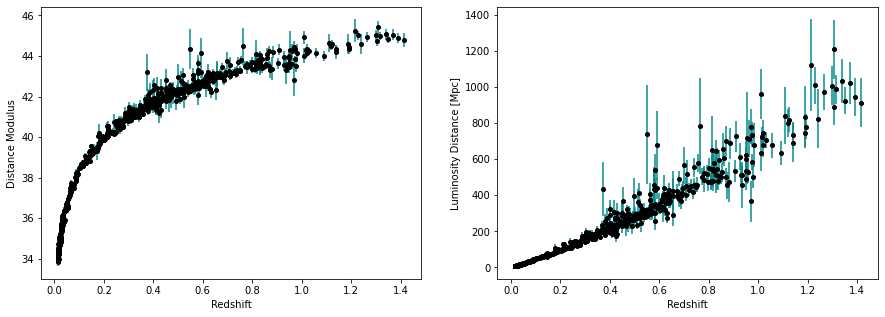

In [7]:
plt.subplots(1, 2, figsize=(15, 5))

# Plot distance modulus versus redshift (original data)
plt.subplot(1, 2, 1)
plt.xlabel("Redshift")
plt.ylabel("Distance Modulus")
plt.errorbar(zs, mm, yerr=dm, fmt='o', color='black', ecolor='darkcyan', markersize=4)

# Plot luminosity distance versus redshift
plt.subplot(1, 2, 2)
plt.xlabel("Redshift")
plt.ylabel("Luminosity Distance [Mpc]")
plt.errorbar(zs, dMpc, yerr=dMe, fmt='o', color='black', ecolor='darkcyan', markersize=4)

## Bayes' Theorem: Likelihood, Prior, Posterior (and Evidence...)

The **conditional probability of A given that B is true** is denoted with $P(A|B)$ (read: *probability of A given B*). 
Did A happen? Then B has probability $P(B|A)$ of happening.

[**Bayes' Theorem**](https://en.wikipedia.org/wiki/Bayes%27_theorem) is simply a reflection of the symmetry of the concept of joint probability:

$$
P(A|B)P(B) = P(B|A)P(A)
$$

In physics, our goal is often to determine how likely the values of some parameters $\theta$ are, given how well they reproduce the data $D$. 
We write Bayes' theorem in the following equivalent form:

$$
P(\theta | D) = \frac{P(D|\theta)P(\theta)}{P(D)}
$$

The various terms conventionally take the names:

$$
\begin{aligned}
P(\theta | D) & && \text{Posterior}
\\
P(D | \theta)& && \text{Likelihood}
\\
P(\theta) & && \text{Prior}
\\
P(D) & && \text{Evidence}
\end{aligned}
$$

### Posterior

What does the data tell us about the model parameters? The answer is the *posterior probability distribution*, often (but not necessarily) expressed as average $\pm$ standard deviation

$$
\theta_i = \bar\theta_i \pm \sigma_i
$$

This is the ultimate goal of our analysis.

### Prior
$$\require{amsmath}$$
The *prior* quantifies our degree of prior belief in the model parameters. It can contain the results of previous experiments, or theoretical considerations (for instance, that certain parameters cannot be negative, etc.). 
When we do *not* have compelling prior knowledge about a parameter, we generally use a *non-informative* prior probability distribution, most often related to the [uniform distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution)

$$
\begin{aligned}
    \text{Uniform} & && \theta \in \text{Uniform}[\theta_{\rm min}, \theta_{\rm max}]
    \\
    \text{Log Uniform} & && \log\theta \in \text{Uniform}[\log\theta_{\rm min}, \log\theta_{\rm max}]
\end{aligned}
$$


### Likelihood

The measure of how well our model reproduces the data is the **likelihood** $\mathcal L$. For normal (=Gaussian), uncorrelated data $\mu_i$ with errors $\sigma_i$ ($i = \{1,580\}$), the likelihood is related to the famous [**chi-squared**](https://en.wikipedia.org/wiki/Chi-square_distribution) via

$$
P(D | \theta) \equiv \mathcal L = \exp\left(-\frac{\chi^2}{2}\right)
\qquad
\qquad
\boxed{
\chi^2 \equiv \sum_{i=1}^{580} \frac{\left(\mu_i^{(\rm theor)} - \mu_i^{(\rm obs)}\right)^2}{\sigma_i^2}
}
\tag*{(4)}
$$

A *high likelihood* corresponds to a *low chi squared*.

In principle, we could attack the problem brute-force: create a grid of values for $h$, $\Omega_m$, $\Omega_\Lambda$, calculate the likelihood for each combination, and create a profile for the likelihood. 

In practical cases, however, this is not only sub-optimal but sometimes **impossible**. Think of complicated models with 20+ free parameters (this is not that unusual in physics, by the way). Even a very coarse grained grid of 100 values for each parameter would result in more than$10^{40}$ (!!!) different parameter combination to be tested. You can probably understand why this is undesirable.

## Markov-Chain Monte Carlo

Markov-Chain Monte Carlo techniques are a class of methods to sample a probability distribution, in our case the **posterior distribution**. Among these, a very popular one is the [**Metropolis-Hastings**](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm, which is what we will use.

Schematically, the algorithm works as follows:
* Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and calculate the likelihood $\mathcal L_{\rm old}$
* Propose a new set of parameters $\theta_{\rm prop}$, calculate the new corresponding likelihood $\mathcal L_{\rm prop}$. How you propose the new parameters is not essential as long as the probability of going from one set of parameters to the next is the same as the inverse: $P(\theta_a \to \theta_b) = P(\theta_b \to \theta_a)$. For this, we normally take Gaussian displacements with some (relatively small) standard deviation.
* Compare the new and old likelihoods:
    * If $\mathcal L_{\rm prop} > \mathcal L_{\rm old}$, accept the step: $\theta_{\rm new} = \theta_{\rm prop}$
    * Otherwise, accept with probability $P_{\rm accept} = \mathcal L_{\rm prop}/\mathcal L_{\rm old}$
* If accepted, $\theta_{\rm new} = \theta_{\rm prop}$ and record the step; otherwise, $\theta_{\rm new} = \theta_{\rm old}$ (no re-recording)
* Update $\theta_{\rm old} = \theta_{\rm new}$
* Repeat

<span style="color:gray">
The MC chain keeps going until the desired number of steps or, ideally, when a suitable convergence test, like for example the <a href="https://bookdown.org/rdpeng/advstatcomp/monitoring-convergence.html"><b><u>Gelman-Rubin test</u></b></a>, is satisfied. 
Today we will just set a limit to the total number of steps, but please feel free to implement and test your favourite convergence test!
</span>

Looking at equation (4), you can convince yourself that
$$
\frac{\mathcal L_a}{\mathcal L_b} = \exp\left(\frac{\chi_b^2 - \chi_a^2}{2}\right)
$$
 
* Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and the corresponding chi squared $\chi_{\rm old}^2$ (to be clear, for us this implies calculating a series of 580 integrals and comparing each with the observed values)
* Propose new parameters $\theta_{\rm prop}$ and calculate the corresponding chi squared $\chi_{\rm prop}^2$
* Draw a random number $r \in [0,1]$
* Accept the step if 
$$
r < \exp\left(\frac{\chi_{\rm prop}^2 - \chi_i^2}{2}\right)
$$
    * If accepted, update $\theta_{\rm old} = \theta_{\rm prop}$, and record; otherwise, $\theta_{\rm new} = \theta_{\rm old}$ (no re-recording)
* Repeat

Your MC chain will look something like this:

`#Omega_m  Omega_L  h   
 0.297     0.703    69.8
 0.285     0.715    70.1
 0.288     0.712    69.9
`

In [8]:
### <---- YOUR CODE GOES HERE

## GetDist

We will do the plots with [GetDist](https://getdist.readthedocs.io/en/latest/plot_gallery.html).

Removed no burn in


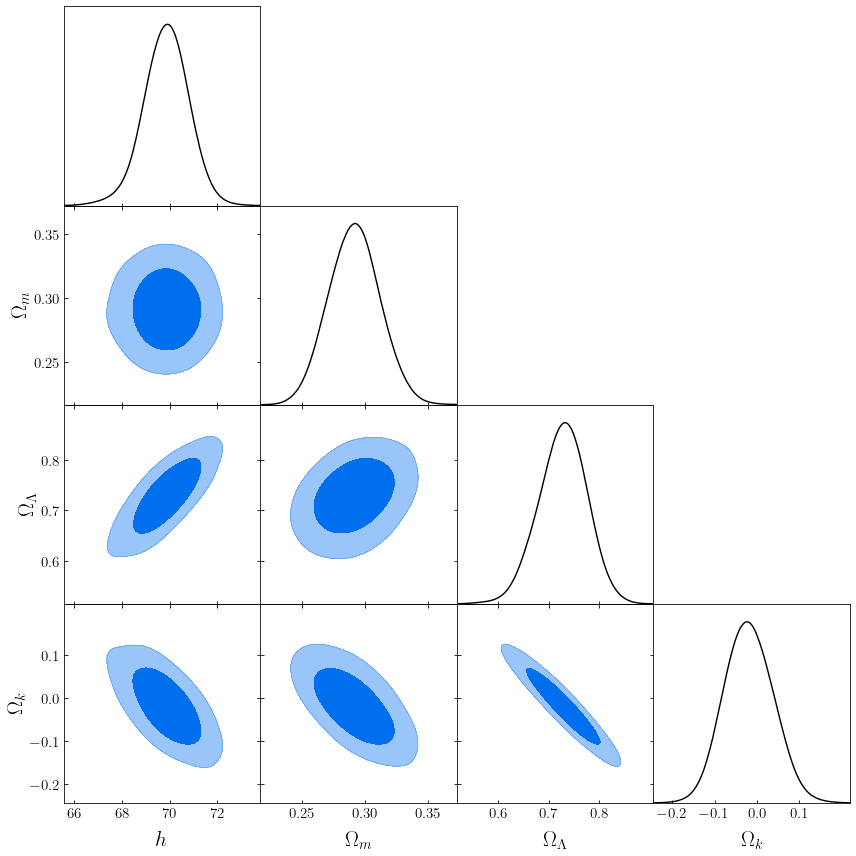

In [9]:
import getdist, IPython
from getdist import plots, MCSamples, loadMCSamples
#print('Version: ',getdist.__version__)
import numpy as np
import pylab
pylab.rc('text',usetex=True)

filename = "YOUR_FILENAME.dat" # <-- PUT YOUR FILENAME HERE
file = np.loadtxt(filename,skiprows = 0)

OmegaM, OmegaL, h = file[:,0], file[:,1], file[:,2]
Omegak = 1. - OmegaM - OmegaL

my_labels = [r'$h$', r'$\Omega_m$', r'$\Omega_\Lambda$', r'$\Omega_k$']
my_names = ['h', 'OmegaM', 'OmegaL', 'Omegak']
my_samples = np.array([h, OmegaM, OmegaL, Omegak])
l1 = len(h)
dim = 4

my_samples = np.transpose(np.reshape(my_samples,(dim,int(my_samples.size/dim))))
samples1 = MCSamples(samples = my_samples, labels = my_labels, names = my_names, label = 'SNIa')

#Triangle corner plot
mylw = 1.42
j = plots.getSubplotPlotter(subplot_size=3)
j.settings.axes_labelsize=22
j.settings.axes_fontsize=16
j.triangle_plot(samples1,
                filled = True,
                line_args = {'lw':mylw},
                )